In [37]:
# Step 1:

# Importing necessary libraries for data processing and machine learning
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # For transforming text data into numerical features
from sklearn.decomposition import TruncatedSVD  # For dimensionality reduction (SVD)
from sklearn.neighbors import NearestNeighbors  # For finding nearest neighbors (used in recommendation systems)

# Load the dataset from the specified Excel file
# 'na_values' argument is used to treat certain strings as NaN (missing values)
data = pd.read_excel('innovius_case_study_data.xlsx', engine='openpyxl', na_values=['NA', 'null', 'missing', 'N/A', 'NaN'])

# Display the first few rows of the dataset to inspect the data
data.head()


,Name,Website,Organization Id,Top Level Category,Secondary Category,Employee Count,Description,Sourcscrub Description,Description.1
0,ClosingLock,closinglock.com,223865172,NaN,NaN,21,Closinglock is a company that provides wire tr...,NaN,Real Estate Wire Fraud Prevention Solution
1,"Daloopa, Inc.",daloopa.com,284044302,IT Management,Data Extraction,226,Discover how the power of over 100 AI algorith...,"Daloopa, Inc. is the only AI solution for inve...",AI-driven enterprise data that can be trusted
2,"Daloopa, Inc.",daloopa.com,284044302,IT Management,Data Extraction,226,Discover how the power of over 100 AI algorith...,"Daloopa, Inc. is the only AI solution for inve...",AI-driven enterprise data that can be trusted
3,UpSmith,upsmith.com,283999461,NaN,NaN,11,Transforming the future of work.,"UpSmith, Inc. is a provider of a skilled labor...",Significantly enhancing lives by giving people...
4,Equal Ventures,equal.vc,160422940,NaN,NaN,5,Equal Ventures is a venture capital firm that ...,NaN,NaN


/var/folders/9l/_pqk33s55lj4hnn8gqrbk3580000gn/T/ipykernel_61429/623279694.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index, y=missing_data.values, hue=None, palette='viridis')  # Plot the missing data


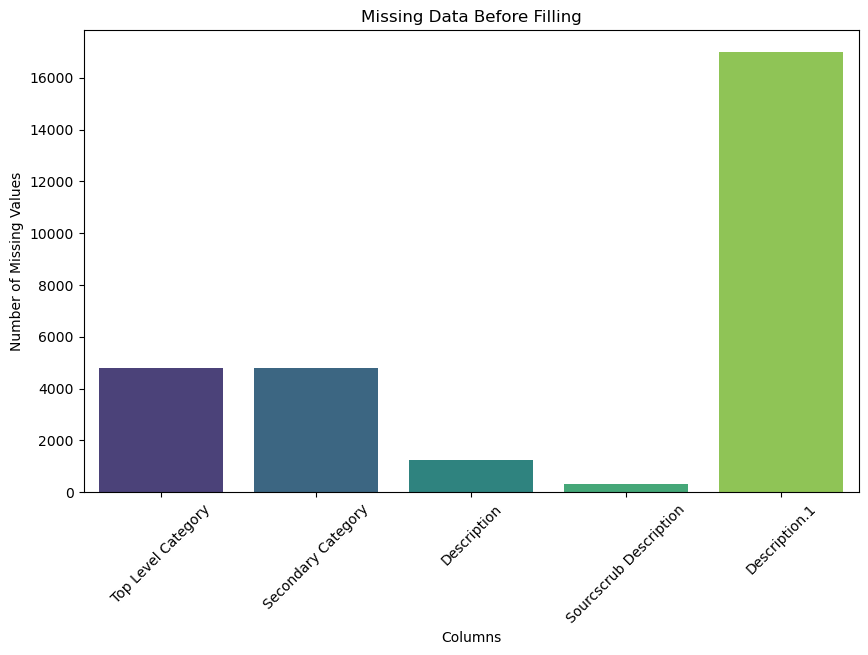

In [38]:
# Importing libraries for visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
import seaborn as sns  # For statistical data visualization based on matplotlib

# Step 2: Visualize Missing Values Before Filling
def visualize_missing(data, title='Missing Data Before Filling'):
    # Calculate the number of missing values per column
    missing_data = data.isnull().sum()
    
    # Filter out columns with no missing values
    missing_data = missing_data[missing_data > 0]

    # Create a bar plot to visualize the number of missing values in each column
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    sns.barplot(x=missing_data.index, y=missing_data.values, hue=None, palette='viridis')  # Plot the missing data
    plt.title(title)  # Set the plot title
    plt.xlabel('Columns')  # Set the x-axis label
    plt.ylabel('Number of Missing Values')  # Set the y-axis label
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.show()  # Display the plot

# Visualize missing data before filling
visualize_missing(data, 'Missing Data Before Filling')


In [39]:
# Step 3: Data Preprocessing ###

# Check for missing values and fill with 'missing_data' for text fields
text_fields = ['Description', 'Sourcscrub Description', 'Top Level Category', 'Secondary Category']

# Iterate over each text field to check and fill missing values
for field in text_fields:
    # Check for NaN or None values in the text fields
    if data[field].isnull().any():
        print(f"Missing values found in '{field}'. Filling with 'missing_data'.")
    
    # Fill missing values with 'missing_data' to ensure consistency
    data[field] = data[field].fillna('missing_data')

# Fill missing values in 'Employee Count' with the median (since it's a numerical field)
if data['Employee Count'].isnull().any():
    print("Missing values found in 'Employee Count'. Filling with median value.")
    data['Employee Count'] = data['Employee Count'].fillna(data['Employee Count'].median())

# If 'Description.1' has a large number of missing values, fill it with 'missing_data' or drop it
if data['Description.1'].isnull().sum() > len(data) * 0.5:  # 50% missing data threshold
    print("High proportion of missing values in 'Description.1'. Filling with 'missing_data'.")
    data['Description.1'] = data['Description.1'].fillna('missing_data')
else:
    # If the missing data is not too high, fill it with the mode (most frequent value) or use other imputation strategies
    print("Missing values in 'Description.1' are relatively low. Filling with mode.")
    data['Description.1'] = data['Description.1'].fillna(data['Description.1'].mode()[0])

# Combine relevant text fields into a single 'combined_text' column for further analysis
data['combined_text'] = data['Description'] + ' ' + data['Sourcscrub Description'] + ' ' + \
                        data['Top Level Category'] + ' ' + data['Secondary Category']

# Optional: Check if 'combined_text' contains any missing values after combining
if data['combined_text'].isnull().any():
    print("Missing values found in 'combined_text'. Filling with 'missing_data'.")
    data['combined_text'] = data['combined_text'].fillna('missing_data')

# After handling missing values, check the number of missing values again across the dataset
missing_values_after_fill = data.isnull().sum()
print("Missing values after filling:")
print(missing_values_after_fill)


Missing values found in 'Description'. Filling with 'missing_data'.
Missing values found in 'Sourcscrub Description'. Filling with 'missing_data'.
Missing values found in 'Top Level Category'. Filling with 'missing_data'.
Missing values found in 'Secondary Category'. Filling with 'missing_data'.
Missing values in 'Description.1' are relatively low. Filling with mode.
Missing values after filling:
Name                      0
Website                   0
Organization Id           0
Top Level Category        0
Secondary Category        0
Employee Count            0
Description               0
Sourcscrub Description    0
Description.1             0
combined_text             0
dtype: int64


In [40]:
### Step 4: Feature Extraction with TF-IDF ###

# Convert text data ('combined_text' column) to a TF-IDF (Term Frequency-Inverse Document Frequency) matrix
# This transforms the text into numerical features that can be used for machine learning models
# 'stop_words='english'' removes common English words like 'the', 'and', etc., from the analysis
# 'max_features=5000' limits the number of features to the top 5000 most relevant words
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Apply the vectorizer to the 'combined_text' column to generate the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(data['combined_text'])



In [41]:
### Step 5: Dimensionality Reduction with Truncated SVD ###

# Reduce the dimensions of the TF-IDF matrix to save memory and improve computational efficiency
# Truncated SVD (Singular Value Decomposition) is used for dimensionality reduction, especially for sparse matrices
# 'n_components=1000' specifies the number of components to keep after the reduction
svd = TruncatedSVD(n_components=1000)  

# Apply Truncated SVD to the TF-IDF matrix to obtain the reduced feature matrix
tfidf_reduced = svd.fit_transform(tfidf_matrix)


In [42]:
### Step 6: Build Nearest Neighbors Model for Similarity Search ###

# Initialize the NearestNeighbors model to find similar items based on the reduced TF-IDF features
# 'n_neighbors=5' specifies that the model will return the 5 nearest neighbors for a given data point
# 'metric='cosine'' sets the similarity measure to cosine distance, which is commonly used for text data
nearest_neighbors = NearestNeighbors(n_neighbors=5, metric='cosine')

# Fit the NearestNeighbors model on the reduced TF-IDF feature matrix to enable similarity search
nearest_neighbors.fit(tfidf_reduced)



NearestNeighbors(metric='cosine')

In [43]:
import pickle  # Importing pickle library to save Python objects to disk

# Save components (such as models and data) to disk using pickle for future use or deployment
# Each object is being saved in binary mode ('wb') to the respective file

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)  # Save the trained TF-IDF vectorizer

with open('svd.pkl', 'wb') as f:
    pickle.dump(svd, f)  # Save the Truncated SVD model

with open('nearest_neighbors.pkl', 'wb') as f:
    pickle.dump(nearest_neighbors, f)  # Save the Nearest Neighbors model

with open('tfidf_reduced.pkl', 'wb') as f:
    pickle.dump(tfidf_reduced, f)  # Save the reduced TF-IDF matrix

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)  # Save the dataset with all preprocessing applied

# Print confirmation message after saving the models and data successfully
print("Models and data saved successfully.")


Models and data saved successfully.


In [44]:
### Step 7: Function to Retrieve Top-N Similar Companies ###

def get_similar_companies(company_index, top_n=5):
    # Use the Nearest Neighbors model to find the top-N similar companies based on their TF-IDF representation
    # 'company_index' is the index of the company in the dataset whose similar companies are to be retrieved
    # 'top_n' specifies how many similar companies to return (default is 5)
    
    # Get the nearest neighbors (distances and indices) of the company at 'company_index'
    # The 'kneighbors' method finds the 'top_n' nearest neighbors in the reduced TF-IDF matrix
    distances, indices = nearest_neighbors.kneighbors([tfidf_reduced[company_index]], n_neighbors=top_n)
    
    # Create a list of results containing the company names and their similarity scores (1 - distance)
    # '1 - dist' converts the distance metric to a similarity score where 1 is most similar
    results = [(data['Name'].iloc[idx], 1 - dist) for idx, dist in zip(indices[0], distances[0])]
    
    # Return the list of top-N similar companies along with their similarity scores
    return results


In [45]:
# Example: Get top 5 similar companies for a sample company

# 'sample_company_index' is the index of the sample company in the dataset (adjust it based on your data)
# For this example, it's set to 0, which corresponds to the first company in the dataset
sample_company_index = 0  # Adjust this index based on the dataset

# Retrieve the name of the company at 'sample_company_index' from the 'Name' column in the dataset
sample_company_name = data['Name'].iloc[sample_company_index]

# Optionally, you can print the sample company name to verify
print(f"Sample company: {sample_company_name}")


Sample company: ClosingLock


In [46]:
# Print the top 5 similar companies to the sample company

# Print a message with the sample company's name
print(f"\nTop 5 similar companies to '{sample_company_name}':")

# Call the 'get_similar_companies' function to retrieve the top 5 similar companies for the sample company
# 'sample_company_index' is the index of the sample company, and 'top_n=5' specifies the number of similar companies
similar_companies = get_similar_companies(sample_company_index, top_n=5)

# Loop through the list of similar companies and print each company's name along with its similarity score
for company, score in similar_companies:
    print(f"{company} - Similarity Score: {score:.4f}")  # Print the company name and similarity score with 4 decimal places



Top 5 similar companies to 'ClosingLock':
ClosingLock - Similarity Score: 1.0000
Fraud.net - Similarity Score: 0.5358
SQN Banking System - Similarity Score: 0.5340
Kount - Similarity Score: 0.5286
Ravelin - Similarity Score: 0.5188
